## Load Libraries

In [35]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [36]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [37]:
#load the datasets

dataframe=pd.read_csv("Desktop\\airline-passengers.csv",usecols=[1])
dataset=dataframe.values
dataset=dataset.astype('float32')

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. 
It can be a good practice to rescale the data to the range of 0-to-1, also called normalizing.

We can easily normalize the dataset using the MinMaxScaler preprocessing class from the scikit-learn library.

In [38]:
#normalise the dataset
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(dataset)

In [39]:
# split into train and test sets

train_size=int(len(dataset)*0.67)
test_size=len(dataset)-train_size
train,test=dataset[0:train_size,:],dataset[train_size:len(dataset),:]
print(len(train),len(test))

96 48


Now we can define a function to create a new dataset, as described above.

The function takes two arguments: the dataset, which is a NumPy array that we want to convert into a dataset, and the look_back, which is the number of previous time steps to use as input variables to predict the next time period — in this case defaulted to 1.

This default will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).

In [40]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [41]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

The LSTM network expects the input data (X) to be provided with a specific array structure in the form of: [samples, time steps, features].

Currently, our data is in the form: [samples, features] and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using numpy.reshape() as follows:

In [42]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an output layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. The network is trained for 100 epochs and a batch size of 1 is used.

In [43]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 1s - loss: 0.0413
Epoch 2/100
 - 0s - loss: 0.0201
Epoch 3/100
 - 0s - loss: 0.0145
Epoch 4/100
 - 0s - loss: 0.0131
Epoch 5/100
 - 0s - loss: 0.0121
Epoch 6/100
 - 0s - loss: 0.0111
Epoch 7/100
 - 0s - loss: 0.0102
Epoch 8/100
 - 0s - loss: 0.0093
Epoch 9/100
 - 0s - loss: 0.0081
Epoch 10/100
 - 0s - loss: 0.0071
Epoch 11/100
 - 0s - loss: 0.0062
Epoch 12/100
 - 0s - loss: 0.0053
Epoch 13/100
 - 0s - loss: 0.0045
Epoch 14/100
 - 0s - loss: 0.0038
Epoch 15/100
 - 0s - loss: 0.0033
Epoch 16/100
 - 0s - loss: 0.0029
Epoch 17/100
 - 0s - loss: 0.0026
Epoch 18/100
 - 0s - loss: 0.0024
Epoch 19/100
 - 0s - loss: 0.0022
Epoch 20/100
 - 0s - loss: 0.0022
Epoch 21/100
 - 0s - loss: 0.0021
Epoch 22/100
 - 0s - loss: 0.0021
Epoch 23/100
 - 0s - loss: 0.0021
Epoch 24/100
 - 0s - loss: 0.0021
Epoch 25/100
 - 0s - loss: 0.0020
Epoch 26/100
 - 0s - loss: 0.0021
Epoch 27/100
 - 0s - loss: 0.0020
Epoch 28/100
 - 0s - loss: 0.0020
Epoch 29/100
 - 0s - loss: 0.0020
Epoch 30/100
 - 0s - lo

Once the model is fit, we can estimate the performance of the model on the train and test datasets. This will give us a point of comparison for new models.

Note that we invert the predictions before calculating error scores to ensure that performance is reported in the same units as the original data (thousands of passengers per month).

In [44]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.92 RMSE
Test Score: 47.53 RMSE


We can see that the model has an average error of about 23 passengers (in thousands) on the training dataset, and about 52 passengers (in thousands) on the test dataset. Not that bad.

Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

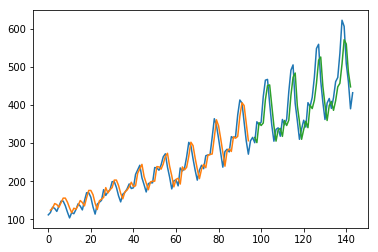

In [45]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()